In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import timedelta
import pandas as pd
import numpy as np
import warnings
import os.path
import swifter
import pickle
import copy
import sys
import re
warnings.filterwarnings('ignore')

# Local Modules
#sys.path.insert(0, os.path.abspath('~/PycharmProjects/platform_migrations/'))
from helpers.regression_helpers import get_slice_date_venue, set_intervention_stuff, get_coms
from helpers.regression_helpers import regression_helper, get_content_helper
from helpers.vars import interventions, interventions_helper, int_ls, int_c, grace_period, exclude_dates
from helpers.plot import plot_intervention, set_size

exclude_dates2 = copy.deepcopy(exclude_dates)
exclude_dates2["/r/Incels"].append([pd.to_datetime("2017-12-03"), pd.to_datetime("2017-12-03")] )

In [3]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'serif',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)
DATA_PATH = "./data_gc/"

# Activity

In [4]:
df_all = pd.read_csv("./data/reproducibility_data/gc/activity_agg.csv")
df_all["date_post"] = pd.to_datetime(df_all["date_post"])

In [5]:
df_all = df_all.rename({
    "first": "newcomers",
    "id": "num_posts",
    "author": "num_users",
    "idpauthor": "num_posts_per_user"
}, axis=1)

In [6]:
df_all['venue'].unique()

array(['/r/Incels', '/r/The_Donald', 'gendercritical'], dtype=object)

In [7]:
exclude_dates2["gendercritical"] = [(pd.to_datetime("2020-06-29"), pd.to_datetime("2020-06-29"))] 

In [8]:
grace_period["gendercritical"] = (pd.to_datetime("2020-06-14"), pd.to_datetime("2020-07-14"))

In [9]:
exclude_dates2, grace_period

({'/r/Incels': [(Timestamp('2017-09-20 00:00:00'),
    Timestamp('2017-09-28 00:00:00')),
   (Timestamp('2017-07-23 00:00:00'), Timestamp('2017-08-08 00:00:00')),
   [Timestamp('2017-12-03 00:00:00'), Timestamp('2017-12-03 00:00:00')]],
  '/r/The_Donald': [(Timestamp('2019-11-21 00:00:00'),
    Timestamp('2019-11-22 00:00:00')),
   (Timestamp('2020-02-05 00:00:00'), Timestamp('2020-02-05 00:00:00'))],
  'gendercritical': [(Timestamp('2020-06-29 00:00:00'),
    Timestamp('2020-06-29 00:00:00'))]},
 {'/r/The_Donald': (Timestamp('2020-02-11 00:00:00'),
   Timestamp('2020-03-12 00:00:00')),
  '/r/Incels': (Timestamp('2017-10-23 00:00:00'),
   Timestamp('2017-11-22 00:00:00')),
  'gendercritical': (Timestamp('2020-06-14 00:00:00'),
   Timestamp('2020-07-14 00:00:00'))})

In [10]:
# set_intervention_stuff(df_all,'gendercritical',pd.to_datetime("2020-06-29"))

In [11]:
# def get_days(x):
#     if str(type(x))!="<class 'float'>":
#         return x.days
#     return x

In [12]:
# df_all['date_idx'] = df_all['date_idx'].apply(get_days)

## Regression table 3a

In [13]:
# This does all regression! ~Magic~
np.random.seed(12)

df_table, df_all = regression_helper(df_all, 
    venues=["/r/The_Donald", "/r/Incels",'gendercritical'],
    vals=["num_posts", "num_users", "num_posts_per_user", "newcomers"],
    exclude_dates=exclude_dates,
    grace_period=grace_period,
     name_v="activity",
    out_dir = "./data_gc/",
    round_val=5)

tmp = df_table.copy(deep=True)

map_y_order = {
"newcomers": 4,
"num_posts": 3,
"num_users": 2,
"num_posts_per_user": 1
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x])


map_y = {
    "newcomers": "\#newcomers",
    "num_posts": "\#posts",
    "num_users": "\#users",
    "num_posts_per_user": "\#posts/\#users",
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
# tmp["$\gamma$"] = "-"

tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp = tmp[["venue", "val", "Intercept", "date_idx", "intervention_flag", "date_idx:intervention_flag", 
           "rsquared"]]

tmp.Intercept = tmp.Intercept.apply(lambda x: x[:x.find("}")]+"}$")
tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept": r'$\alpha_0$',
           "date_idx": r'$\beta_0$',
           "intervention_flag": r'$\alpha$',
           "date_idx:intervention_flag": r'$\beta$', 
           }, axis=1)

print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &                 &     $\alpha_0$ &                    $\beta_0$ &                         $\alpha$ &                      $\beta$ &   $R^2$ \\
Venue & Statistic &                &                              &                                  &                              &         \\
\midrule
gendercritical & \#newcomers &   $88.1^{***}$ &        $0.2^{*} (0.05, 0.4)$ &       $-54.4^{***} (-74, -34.7)$ &    $-0.5^{***} (-0.7, -0.3)$ &  $0.69$ \\
          & \#posts &   $1475^{***}$ &        $3.5^{} (-0.04, 7.1)$ &    $-1154^{***} (-1466, -841.4)$ &           $1.9^{} (-2, 5.7)$ &   $0.5$ \\
          & \#users &    $543^{***}$ &        $0.9^{} (-0.05, 1.8)$ &  $-443.7^{***} (-528.5, -358.8)$ &         $0.4^{} (-0.7, 1.4)$ &  $0.78$ \\
          & \#posts/\#users &    $2.6^{***}$ &   $0.002^{} (-0.001, 0.004)$ &           $0.9^{***} (0.4, 1.4)$ &   $0.001^{} (-0.004, 0.007)$ &  $0.67$ \\
/r/The_Donald & \#newcomers &  $214.7^{***}$ &      

$\alpha_0$                    $\beta_0$  \
Venue          Statistic                                                     
gendercritical \#newcomers       $88.1^{***}$        $0.2^{*} (0.05, 0.4)$   
               \#posts           $1475^{***}$        $3.5^{} (-0.04, 7.1)$   
               \#users            $543^{***}$        $0.9^{} (-0.05, 1.8)$   
               \#posts/\#users    $2.6^{***}$   $0.002^{} (-0.001, 0.004)$   
/r/The_Donald  \#newcomers      $214.7^{***}$        $-0.5^{} (-1.3, 0.2)$   
               \#posts          $26650^{***}$       $8.8^{} (-17.9, 35.5)$   
               \#users           $7593^{***}$           $4^{} (-0.5, 8.5)$   
               \#posts/\#users    $3.5^{***}$  $-0.001^{} (-0.003, 0.001)$   
/r/Incels      \#newcomers      $224.9^{***}$       $0.9^{***} (0.5, 1.4)$   
               \#posts           $4840^{***}$      $19.5^{***} (14.1, 25)$   
               \#users          $960.1^{***}$       $3.9^{***} (2.9, 4.9)$   
               \#posts/\#users      $5^{***}$  $-0.001^{} (-0.003, 0.003)$   

                                                       $\alpha$  \
Venue          Statistic                                          
gendercritical \#newcomers           $-54.4^{***} (-74, -34.7)$   
               \#posts            $-1154^{***} (-1466, -841.4)$   
               \#users          $-443.7^{***} (-528.5, -358.8)$   
               \#posts/\#users           $0.9^{***} (0.4, 1.4)$   
/r/The_Donald  \#newcomers         $-77.8^{**} (-127.9, -27.7)$   
               \#posts          $-14416^{***} (-16947, -11886)$   
               \#users             $-4774^{***} (-5184, -4365)$   
               \#posts/\#users           $1.1^{***} (0.9, 1.3)$   
/r/Incels      \#newcomers      $-215.4^{***} (-250.3, -180.5)$   
               \#posts             $-2651^{***} (-3098, -2203)$   
               \#users          $-777.4^{***} (-850.2, -704.6)$   
               \#posts/\#users           $7.4^{***} (6.6, 8.3)$   

                                                    $\beta$   $R^2$  
Venue          Statistic                                             
gendercritical \#newcomers        $-0.5^{***} (-0.7, -0.3)$  $0.69$  
               \#posts                   $1.9^{} (-2, 5.7)$   $0.5$  
               \#users                 $0.4^{} (-0.7, 1.4)$  $0.78$  
               \#posts/\#users   $0.001^{} (-0.004, 0.007)$  $0.67$  
/r/The_Donald  \#newcomers             $0.5^{} (-0.5, 1.4)$  $0.24$  
               \#posts          $120.6^{***} (83.9, 157.2)$  $0.41$  
               \#users             $13.7^{***} (8.1, 19.3)$  $0.85$  
               \#posts/\#users  $0.009^{***} (0.006, 0.01)$  $0.85$  
/r/Incels      \#newcomers        $-0.9^{***} (-1.3, -0.4)$  $0.84$  
               \#posts                 $1.7^{} (-4.8, 8.2)$  $0.55$  
               \#users                $-3^{***} (-4, -2.1)$  $0.93$  
               \#posts/\#users    $0.04^{***} (0.02, 0.05)$  $0.92$

## Figure 3

gendercritical newcomers mean_before 73.17757009345794 intercept_pct -0.743397190293742
gendercritical num_posts mean_before 1273.747663551402 intercept_pct -0.9059879229002649
gendercritical num_users mean_before 491.60747663551405 intercept_pct -0.9025493327249914
gendercritical num_posts_per_user mean_before 2.5480723398752745 intercept_pct 0.353208182481999
/r/Incels newcomers mean_before 151.98058252427185 intercept_pct -1.4172863165963971
/r/Incels num_posts mean_before 3612.1650485436894 intercept_pct -0.7339088785737515
/r/Incels num_users mean_before 669.7184466019418 intercept_pct -1.1607863034748698
/r/Incels num_posts_per_user mean_before 6.009445945928104 intercept_pct 1.231394718678535


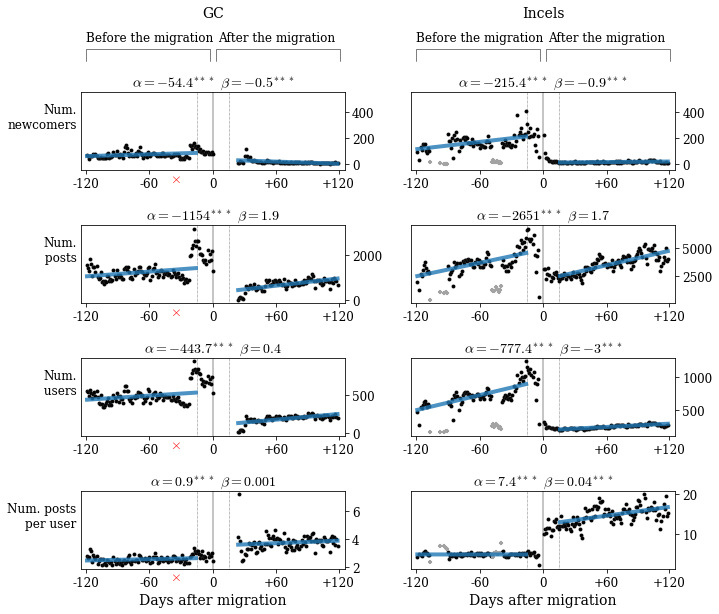

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8.5), sharex=False, gridspec_kw={"wspace":0.25, "hspace":0.7})
table_helper = df_table.set_index(["val", "venue"])

for idx, venue in enumerate(["gendercritical", "/r/Incels"]):
    community = df_all.loc[df_all.venue == venue]
    coms = get_coms(venue, exclude_dates, community)

    for com, marker in zip(coms, ["o", "."]):
        for idy, val in enumerate(["newcomers", "num_posts", "num_users", "num_posts_per_user"]):

            trans = transforms.blended_transform_factory(
            axs[idy, idx].transData, axs[idy, idx].transAxes)
            axs[idy, idx].scatter(com.date_post, com[val], s=15,  
                                  marker="o"if marker=="o" else "P",
                                  alpha=1, linewidths=0.1,#"white",
                                  c="black" if marker=="o" else "#a3a3a3", edgecolors="#a3a3a3")
            axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", lw=4, 
                               alpha=0.8, zorder=4)
            rsquared = table_helper.loc[val,venue].rsquared
            slope = table_helper.loc[val,venue]["date_idx:intervention_flag"].split(";")[0]
            intercept = table_helper.loc[val,venue].intervention_flag.split(";")[0]

            if marker == "o":             

                print(venue, val,
                      "mean_before", np.mean(com[val].values[:len(com)//2]),
                      "intercept_pct", float(re.sub("(\$|\{|\*|\^|\})", "",
                                                    intercept.split("(")[0]))/np.mean(com[val].values[:len(com)//2])
                     )
            
                plt.text(interventions[venue]["Measure"], 1.08, 
                         r"$\alpha=$" + intercept[:intercept.find("(")] + "$" +
                         r" $\beta=$" + slope[:slope.find("(")] + "$",
                         transform=trans, ha='center', size=14)

                if idy == 0:
                    axs[idy, idx].plot([interventions[venue]["Measure"] - timedelta(days=3),
                                        interventions[venue]["Measure"] - timedelta(days=3),
                                        interventions[venue]["Measure"] - timedelta(days=120),
                                       interventions[venue]["Measure"] - timedelta(days=120)],
                             [1.4, 1.55, 1.55, 1.4], transform=trans, clip_on=False, color="black", lw=0.5)
                    axs[idy, idx].plot([interventions[venue]["Measure"] + timedelta(days=3),
                                        interventions[venue]["Measure"] + timedelta(days=3),
                                        interventions[venue]["Measure"] + timedelta(days=120),
                                       interventions[venue]["Measure"] + timedelta(days=120)],
                             [1.4, 1.55, 1.55, 1.4], transform=trans, clip_on=False, color="black", lw=0.5)
                    
                    plt.text(interventions[venue]["Measure"] + timedelta(days=60), 1.65, 
                            "After the migration",
                             transform=trans, ha='center', size=12)
                    plt.text(interventions[venue]["Measure"] - timedelta(days=60), 1.65, 
                            "Before the migration",
                             transform=trans, ha='center', size=12)
            axs[idy, idx].yaxis.tick_right()

    for i in range(4): 
        plot_intervention(axs[i, idx], interventions, venue, "all", interventions_helper, int_ls, int_c, grace_period)
tdm = interventions["gendercritical"]["Measure"]
tdi = interventions["/r/Incels"]["Measure"]
tdelta = timedelta(days=60)
for i in range(4):
    axs[i, 0].set_xticks([tdm -2*tdelta, tdm - tdelta, tdm, tdm + tdelta, tdm + 2*tdelta - timedelta(days=1)])
    axs[i, 1].set_xticks([tdi -2*tdelta, tdi - tdelta, tdi, tdi + tdelta, tdi + 2*tdelta - timedelta(days=1)])
    axs[i, 0].set_xlim([tdm -2*tdelta - timedelta(days=5), tdm + 2*tdelta + timedelta(days=5)])
    axs[i, 1].set_xlim([tdi -2*tdelta - timedelta(days=5), tdi + 2*tdelta + timedelta(days=5)])
    axs[i, 0].set_xticklabels(["-120", "-60", "0", "+60", "+120"])
    axs[i, 1].set_xticklabels(["-120", "-60", "0", "+60", "+120"])
#     axs[i, 0].xaxis.set_major_formatter(mpl.dates.DateFormatter("%d %b %y"))
#     axs[i, 1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%d %b %y"))
axs[0, 0].set_title("GC", pad=75, size=14)
axs[0, 1].set_title("Incels", pad=75, size=14)
axs[1, 0].set_ylabel('Num.\n posts', rotation=0, ha="right", size=12)
axs[2, 0].set_ylabel('Num.\n users', rotation=0, ha="right", size=12)
axs[3, 0].set_ylabel('Num. posts\nper user', rotation=0, ha="right", size=12)
axs[0, 0].set_ylabel('Num.\nnewcomers', rotation=0, ha="right", size=12)
axs[0, 0].set_ylim([-50, 550])
axs[0, 1].set_ylim([-50, 550])

axs[3, 0].set_xlabel("Days after migration")
axs[3, 1].set_xlabel("Days after migration")

for i in range(0, 4):
    trans = transforms.blended_transform_factory(axs[i, 0].transData, axs[i, 0].transAxes)
    plt.text(pd.to_datetime("25-05-2020"), -0.15, r'$\times$', ha="center", color="red", transform=trans)


set_size(fig, (10, 8.5))
fig.savefig(DATA_PATH + "images/rdd_activity.pdf", bbox_inches="tight")

# Content

In [16]:
df_content = pd.read_csv("./data/reproducibility_data/gc/content_agg.csv")
df_norm = pd.read_csv("./data/reproducibility_data/gc/content_agg_fixation_dict.csv")

df_content["date_post"] = pd.to_datetime(df_content["date_post"])
df_norm["date_post"] = pd.to_datetime(df_norm["date_post"])

df_content_matched = pd.read_csv("./data/reproducibility_data/gc/content_matched_agg.csv")
df_norm_matched = pd.read_csv("./data/reproducibility_data/gc/content_matched_agg_fixation_dict.csv")

df_content_matched["date_post"] = pd.to_datetime(df_content_matched["date_post"])
df_norm_matched["date_post"] = pd.to_datetime(df_norm_matched["date_post"])

In [18]:
df_content.columns

Index(['venue', 'date_post', 'SEVERE_TOXICITY', 'SEVERE_TOXICITY80p',
       'fixation_dict_incels', 'fixation_dict_td', 'fixation_dict_gc',
       'NegativeEmotion', 'CoreHostility', 'We', 'They',
       'fixation_dict_incels_norm', 'fixation_dict_td_norm',
       'fixation_dict_gc_norm', 'NegativeEmotion_norm', 'CoreHostility_norm',
       'We_norm', 'They_norm', 'length', 'count_repeated', 'intervention_flag',
       'date_idx'],
      dtype='object')

## Regression Table 3b and 3c

In [19]:
# This does all regression! ~Magic~

np.random.seed(9876789)

tmp_vals = ['fixation_dict_incels', 'fixation_dict_gc', "We", "They" ]

df_table_con, df_content = regression_helper(
    df_content, 
    venues=["gendercritical", "/r/Incels"],
    vals=tmp_vals,
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=7,
    name_v="content",
    out_dir = "./data_gc/"
)

np.random.seed(9876789)

df_table_norm, df_norm = regression_helper(
    df_norm, 
    venues=["gendercritical", "/r/Incels"],
    vals=["SEVERE_TOXICITY", "CoreHostility", "NegativeEmotion"],
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=5,
    name_v="content",
    out_dir = "./data_gc/"
)

# Matched version

np.random.seed(345345)

tmp_vals = ['fixation_dict_incels', 'fixation_dict_gc', "We", "They" ]

df_table_con_matched, df_content_matched = regression_helper(
    df_content_matched, 
    venues=["gendercritical", "/r/Incels"],
    vals=tmp_vals,
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=7,
    name_v="content_matched",
    out_dir = "./data_gc/"
)

np.random.seed(4564564)

df_table_norm_matched, df_norm_matched = regression_helper(
    df_norm_matched, 
    venues=["gendercritical", "/r/Incels"],
    vals=["SEVERE_TOXICITY", "CoreHostility", "NegativeEmotion"],
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=5,
    name_v="content_matched",
    out_dir = "./data_gc/"
)


/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4

In [20]:
tmp = ["SEVERE_TOXICITY", "CoreHostility", "NegativeEmotion"]
x1 = df_table_norm[df_table_norm.val.apply(lambda x: x in tmp)]
x2 = df_table_con[df_table_con.val.apply(lambda x: x not in tmp)]
tmp = pd.concat([x1, x2])#.sort_values(["venue", "val"]).set_index(["venue", "val"])
tmp = tmp[["venue", "val", "Intercept_table", "date_idx_table", "intervention_flag_table", 
           "date_idx:intervention_flag_table", "length_table", "rsquared"]]
tmp = tmp.copy(deep=True)
tmp

map_y_order = {
    "fixation_dict_incels": 7,
    "fixation_dict_gc": 6,
    "SEVERE_TOXICITY": 5,
    "NegativeEmotion": 4,
    "CoreHostility": 3,
    "We": 2,
    "They": 1,
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x] if x in map_y_order else -1)

tmp = tmp.loc[tmp.vals != -1]
tmp = tmp.loc[~((tmp.vals == 7) & (tmp.venue == "/r/The_Donald")) ]
tmp = tmp.loc[~((tmp.vals == 6) & (tmp.venue == "/r/Incels")) ]
map_y = {
    "fixation_dict_incels": "Fix. Dict",
    "fixation_dict_gc":  "Fix. Dict",
    "SEVERE_TOXICITY": "Toxicity",
    "NegativeEmotion": "Neg. Emotion",
    "CoreHostility": "Hostility",
    "We": "We",
    "They": "They"
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept_table": r'$\alpha_0$',
           "date_idx_table": r'$\beta_0$',
           "intervention_flag_table": r'$\alpha$',
           "date_idx:intervention_flag_table": r'$\beta$',
           "length_table": r'$\gamma$',
           }, axis=1)
tmp = tmp.drop(["vals", "$\gamma$"], axis=1)
print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &      &                           $\alpha_0$ &                            $\beta_0$ &                             $\alpha$ &                              $\beta$ &   $R^2$ \\
Venue & Statistic &                                      &                                      &                                      &                                      &         \\
\midrule
gendercritical & Fix. Dict &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &   $nan$ \\
          & Fix. Dict &               $0.7^{***} (0.6, 0.9)$ &       $[10^{-3}] 0.9^{} (-0.3, 2.1)$ &                $0.02^{} (-0.1, 0.2)$ &     $[10^{-3}] -1.9^{} (-3.9, 0.05)$ &  $0.03$ \\
          & Toxicity &              $25.9^{***} (24.7, 27)$ &    $[10^{-3}] -1.7^{} (-15.6, 12.1)$ &                $-2.6^{} (-5.9, 0.7)$ &              $0.02^{} (-0.02, 0.06)$ &  $0.09$ \\
       

$\alpha_0$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict                  $0.7^{***} (0.6, 0.9)$   
               Toxicity                  $25.9^{***} (24.7, 27)$   
               Neg. Emotion                 $1.9^{***} (1.8, 2)$   
               Hostility                  $2.8^{***} (2.6, 2.9)$   
               We                         $0.7^{***} (0.7, 0.8)$   
               They                       $1.7^{***} (1.6, 1.8)$   
/r/Incels      Fix. Dict                  $1.9^{***} (1.6, 2.1)$   
               Toxicity                $37.5^{***} (34.3, 40.7)$   
               Neg. Emotion               $3.2^{***} (2.8, 3.6)$   
               Hostility                  $6.3^{***} (5.4, 7.1)$   
               We                         $0.6^{***} (0.4, 0.9)$   
               They                       $1.2^{***} (0.8, 1.6)$   

                                                       $\beta_0$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict          $[10^{-3}] 0.9^{} (-0.3, 2.1)$   
               Toxicity        $[10^{-3}] -1.7^{} (-15.6, 12.1)$   
               Neg. Emotion      $[10^{-3}] -0.8^{} (-1.9, 0.3)$   
               Hostility          $[10^{-3}] 0.5^{} (-1.4, 2.3)$   
               We                 $[10^{-3}] 0.7^{*} (0.1, 1.4)$   
               They              $[10^{-3}] -0.3^{} (-1.4, 0.8)$   
/r/Incels      Fix. Dict       $[10^{-3}] -1.8^{*} (-3.3, -0.4)$   
               Toxicity          $[10^{-3}] 5.8^{} (-8.2, 19.8)$   
               Neg. Emotion         $[10^{-3}] 1^{} (-0.7, 2.7)$   
               Hostility            $[10^{-3}] 0.4^{} (-3.1, 4)$   
               We                  $[10^{-3}] -1^{} (-2.5, 0.4)$   
               They              $[10^{-3}] -0.3^{} (-2.6, 2.1)$   

                                                        $\alpha$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict                   $0.02^{} (-0.1, 0.2)$   
               Toxicity                    $-2.6^{} (-5.9, 0.7)$   
               Neg. Emotion               $-0.07^{} (-0.4, 0.2)$   
               Hostility                 $-0.3^{} (-0.7, 0.001)$   
               We                         $0.2^{**} (0.06, 0.4)$   
               They                    $-0.3^{***} (-0.5, -0.2)$   
/r/Incels      Fix. Dict               $-0.4^{***} (-0.5, -0.2)$   
               Toxicity                     $0.5^{} (-0.6, 1.7)$   
               Neg. Emotion               $-0.1^{} (-0.3, 0.03)$   
               Hostility                   $0.05^{} (-0.3, 0.4)$   
               We                         $0.06^{} (-0.05, 0.2)$   
               They                       $-0.1^{} (-0.3, 0.04)$   

                                                         $\beta$   $R^2$  
Venue          Statistic                                                  
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   $nan$  
               Fix. Dict        $[10^{-3}] -1.9^{} (-3.9, 0.05)$  $0.03$  
               Toxicity                  $0.02^{} (-0.02, 0.06)$  $0.09$  
               Neg. Emotion       $[10^{-3}] 1.6^{} (-1.9, 5.1)$  $0.02$  
               Hostility          $[10^{-3}] 1.2^{} (-3.2, 5.7)$  $0.12$  
               We            $[10^{-3}] -3.4^{***} (-5.3, -1.5)$   $0.2$  
               They                $[10^{-3}] 2.9^{**} (0.8, 5)$   $0.2$  
/r/Incels      Fix. Dict         $[10^{-3}] 2.4^{**} (0.9, 3.8)$  $0.69$  
               Toxicity         $[10^{-3}] 3.2^{} (-11.8, 18.3)$  $0.19$  
               Neg. Emotion       $[10^{-3}] 1.3^{} (-0.4, 3.1)$  $0.25$  
               Hostility          $[10^{-3}] 2.6^{} (-0.8, 6.1)$  $0.38$  
               W

In [21]:
tmp = ["SEVERE_TOXICITY", "CoreHostility", "NegativeEmotion"]
x1 = df_table_norm_matched[df_table_norm_matched.val.apply(lambda x: x in tmp)]
x2 = df_table_con_matched[df_table_con_matched.val.apply(lambda x: x not in tmp)]
tmp = pd.concat([x1, x2])#.sort_values(["venue", "val"]).set_index(["venue", "val"])
tmp = tmp[["venue", "val", "Intercept_table", "date_idx_table", "intervention_flag_table", 
           "date_idx:intervention_flag_table", "length_table", "rsquared"]]
tmp = tmp.copy(deep=True)
tmp

map_y_order = {
    "fixation_dict_incels": 7,
    "fixation_dict_gc": 6,
    "SEVERE_TOXICITY": 5,
    "NegativeEmotion": 4,
    "CoreHostility": 3,
    "We": 2,
    "They": 1,
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x] if x in map_y_order else -1)

tmp = tmp.loc[tmp.vals != -1]
tmp = tmp.loc[~((tmp.vals == 7) & (tmp.venue == "/r/The_Donald")) ]
tmp = tmp.loc[~((tmp.vals == 6) & (tmp.venue == "/r/Incels")) ]
map_y = {
    "fixation_dict_incels": "Fix. Dict",
    "fixation_dict_gc":  "Fix. Dict",
    "SEVERE_TOXICITY": "Toxicity",
    "NegativeEmotion": "Neg. Emotion",
    "CoreHostility": "Hostility",
    "We": "We",
    "They": "They"
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp
# tmp.Intercept = tmp.Intercept.apply(lambda x: x[:x.find("}")]+"}$")
tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept_table": r'$\alpha_0$',
           "date_idx_table": r'$\beta_0$',
           "intervention_flag_table": r'$\alpha$',
           "date_idx:intervention_flag_table": r'$\beta$',
           "length_table": r'$\gamma$',
           }, axis=1)
tmp = tmp.drop(["vals", "$\gamma$"], axis=1)
print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &      &                           $\alpha_0$ &                            $\beta_0$ &                             $\alpha$ &                              $\beta$ &   $R^2$ \\
Venue & Statistic &                                      &                                      &                                      &                                      &         \\
\midrule
gendercritical & Fix. Dict &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &  $[10^{-3}] 0.001^{} (0.001, 0.001)$ &   $nan$ \\
          & Fix. Dict &               $0.8^{***} (0.7, 0.9)$ &      $[10^{-3}] 2.2^{**} (0.6, 3.8)$ &               $-0.1^{} (-0.4, 0.09)$ &        $[10^{-3}] -1.9^{} (-5, 1.1)$ &  $0.04$ \\
          & Toxicity &            $18.1^{***} (15.9, 20.3)$ &          $-0.04^{*} (-0.07, -0.007)$ &                $7.2^{} (-0.3, 14.8)$ &               $0.02^{} (-0.07, 0.1)$ &  $0.08$ \\
       

$\alpha_0$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict                  $0.8^{***} (0.7, 0.9)$   
               Toxicity                $18.1^{***} (15.9, 20.3)$   
               Neg. Emotion                 $1.8^{***} (1.6, 2)$   
               Hostility                    $2^{***} (1.7, 2.3)$   
               We                         $0.8^{***} (0.7, 0.9)$   
               They                       $1.4^{***} (1.3, 1.5)$   
/r/Incels      Fix. Dict                    $2^{***} (1.7, 2.3)$   
               Toxicity                $35.8^{***} (32.8, 38.9)$   
               Neg. Emotion                 $3^{***} (2.6, 3.4)$   
               Hostility                  $5.9^{***} (5.2, 6.7)$   
               We                         $0.4^{***} (0.3, 0.6)$   
               They                         $1^{***} (0.8, 1.2)$   

                                                       $\beta_0$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict         $[10^{-3}] 2.2^{**} (0.6, 3.8)$   
               Toxicity              $-0.04^{*} (-0.07, -0.007)$   
               Neg. Emotion   $[10^{-3}] -3.3^{*} (-6.5, -0.08)$   
               Hostility           $[10^{-3}] -5^{*} (-9.1, -1)$   
               We                 $[10^{-3}] 1.2^{} (-0.1, 2.5)$   
               They              $[10^{-3}] -2.1^{*} (-4, -0.2)$   
/r/Incels      Fix. Dict       $[10^{-3}] -2.2^{*} (-3.9, -0.4)$   
               Toxicity            $[10^{-3}] 8.3^{} (-7, 23.7)$   
               Neg. Emotion       $[10^{-3}] 0.2^{} (-3.1, 3.5)$   
               Hostility            $[10^{-3}] 0.4^{} (-4.2, 5)$   
               We                 $[10^{-3}] 0.5^{} (-0.6, 1.7)$   
               They            $[10^{-3}] -0.006^{} (-1.7, 1.7)$   

                                                        $\alpha$  \
Venue          Statistic                                           
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   
               Fix. Dict                  $-0.1^{} (-0.4, 0.09)$   
               Toxicity                    $7.2^{} (-0.3, 14.8)$   
               Neg. Emotion                 $0.1^{} (-0.7, 0.9)$   
               Hostility                    $0.8^{} (-0.8, 2.4)$   
               We                          $0.08^{} (-0.2, 0.4)$   
               They                    $-0.3^{*} (-0.5, -0.009)$   
/r/Incels      Fix. Dict               $-0.4^{***} (-0.6, -0.2)$   
               Toxicity                  $-1.9^{*} (-3.3, -0.4)$   
               Neg. Emotion             $-0.3^{*} (-0.5, -0.06)$   
               Hostility                $-0.5^{*} (-0.9, -0.06)$   
               We                      $-0.2^{***} (-0.3, -0.1)$   
               They                    $-0.2^{**} (-0.3, -0.07)$   

                                                         $\beta$   $R^2$  
Venue          Statistic                                                  
gendercritical Fix. Dict     $[10^{-3}] 0.001^{} (0.001, 0.001)$   $nan$  
               Fix. Dict           $[10^{-3}] -1.9^{} (-5, 1.1)$  $0.04$  
               Toxicity                   $0.02^{} (-0.07, 0.1)$  $0.08$  
               Neg. Emotion      $[10^{-3}] 3.6^{} (-6.5, 13.7)$  $0.01$  
               Hostility        $[10^{-3}] 2.7^{} (-16.4, 21.9)$  $0.04$  
               We                $[10^{-3}] -3.6^{} (-7.6, 0.4)$  $0.16$  
               They              $[10^{-3}] 8^{***} (4.5, 11.5)$  $0.11$  
/r/Incels      Fix. Dict            $[10^{-3}] 1.3^{} (-1, 3.5)$  $0.67$  
               Toxicity                 $0.02^{} (-0.001, 0.04)$  $0.14$  
               Neg. Emotion      $[10^{-3}] 3.7^{*} (0.05, 7.3)$  $0.07$  
               Hostility        $[10^{-3}] 8.1^{**} (2.4, 13.7)$  $0.13$  
               W

## Figures 6 and 8

gendercritical fixation_dict_gc mean_before 0.6703368228250857 intercept_pct 0.029835747222883353
gendercritical We mean_before 0.6749213746858552 intercept_pct 0.2963308134863721
gendercritical They mean_before 1.7364021544436605 intercept_pct -0.17277103649765935
/r/Incels fixation_dict_incels mean_before 1.9329144620045748 intercept_pct -0.20694138714507343
/r/Incels We mean_before 0.5835850297940732 intercept_pct 0.10281278123459045
/r/Incels They mean_before 1.3963635919734316 intercept_pct -0.071614585609951
gendercritical SEVERE_TOXICITY mean_before 25.469584002999625 intercept_pct -0.10208254676220038
gendercritical CoreHostility mean_before 2.663776419167852 intercept_pct -0.11262206461521204
gendercritical NegativeEmotion mean_before 1.9417924637514448 intercept_pct -0.03604916658537419
/r/Incels SEVERE_TOXICITY mean_before 39.71603859152873 intercept_pct 0.012589372397947262
/r/Incels CoreHostility mean_before 4.951453601801434 intercept_pct 0.010098044740196906
/r/Incels Ne

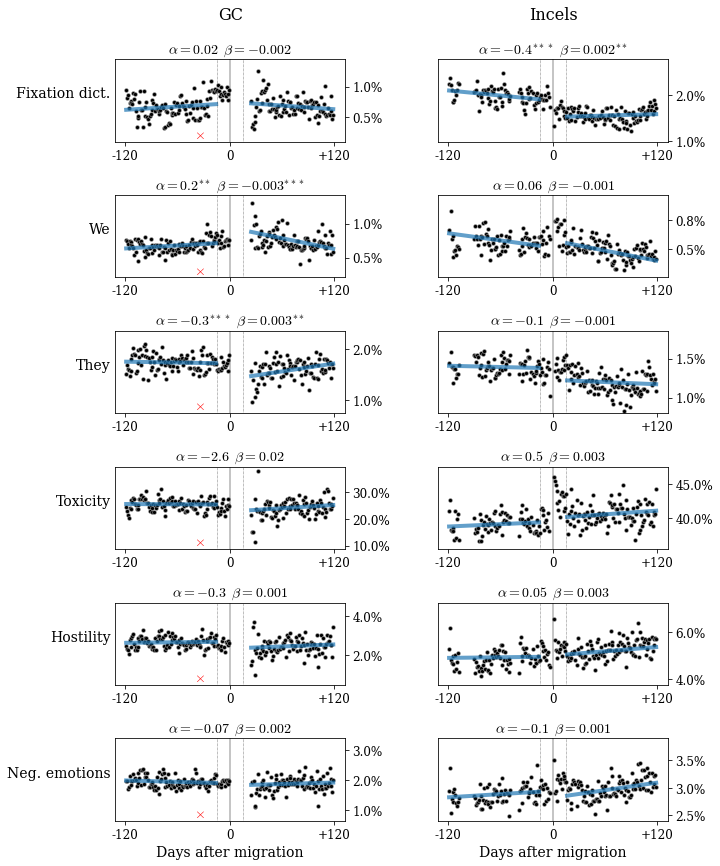

gendercritical fixation_dict_gc mean_before 0.6703368228250857 intercept_pct -0.1491787361144168
gendercritical We mean_before 0.6749213746858552 intercept_pct 0.11853232539454883
gendercritical They mean_before 1.7364021544436605 intercept_pct -0.17277103649765935
/r/Incels fixation_dict_incels mean_before 1.9329144620045748 intercept_pct -0.20694138714507343
/r/Incels We mean_before 0.5835850297940732 intercept_pct -0.34270927078196817
/r/Incels They mean_before 1.3963635919734316 intercept_pct -0.143229171219902
gendercritical SEVERE_TOXICITY mean_before 25.469584002999625 intercept_pct 0.2826901294953241
gendercritical CoreHostility mean_before 2.663776419167852 intercept_pct 0.3003255056405655
gendercritical NegativeEmotion mean_before 1.9417924637514448 intercept_pct 0.05149880940767741
/r/Incels SEVERE_TOXICITY mean_before 39.71603859152873 intercept_pct -0.04783961511219959
/r/Incels CoreHostility mean_before 4.951453601801434 intercept_pct -0.10098044740196906
/r/Incels Negati

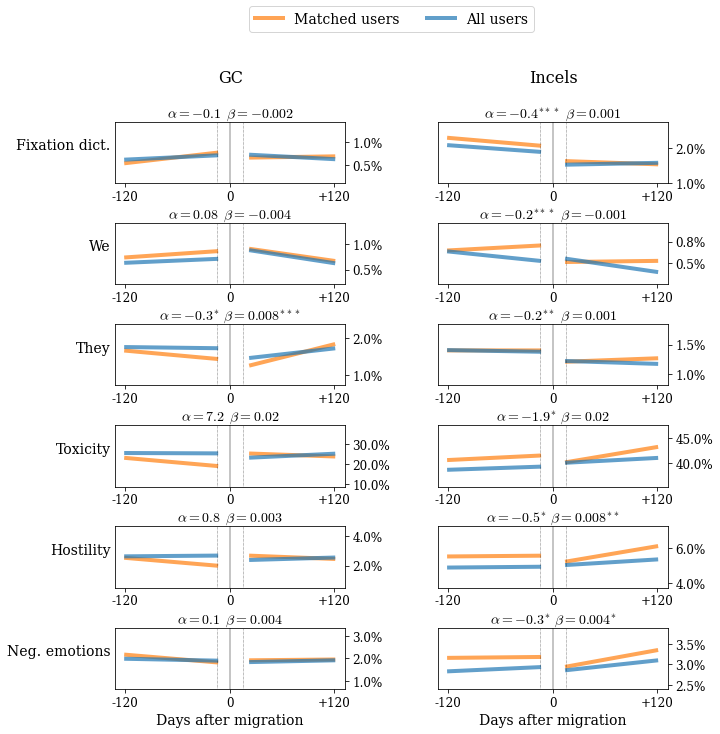

In [22]:
for plot_kind in ["normal", "matched"]:
    
    if plot_kind == "normal":
        fig, axs_ = plt.subplots(6, 2, figsize=(10, 12),gridspec_kw={"wspace":0.4, "hspace":0.65})
    else:
        fig, axs_ = plt.subplots(6, 2, figsize=(10, 9.3),gridspec_kw={"wspace":0.4, "hspace":0.65})


    for df_tmp, df_table, df_tmp_matched, df_table_matched, vars_to_plot, title_vars, fig_name, axs in zip(
        [df_content, df_norm],
        [df_table_con, df_table_norm],
        [df_content_matched, df_norm_matched],
        [df_table_con_matched, df_table_norm_matched],
        [["fixdict", 'We', 'They'], ["SEVERE_TOXICITY", "CoreHostility", "NegativeEmotion"]],
        [["Fixation dict.", "We", "They"], ["Toxicity", "Hostility", "Neg. emotions"]],
        ["_1", "_2"],
        [axs_[:3, :], axs_[3:, :] ]):


        table_helper = df_table.set_index(["val", "venue"])
        table_helper2 = df_table_matched.set_index(["val", "venue"])


        for idx, venue in enumerate(["gendercritical", "/r/Incels"]):

            community = df_tmp.loc[df_tmp.venue == venue]
            community2 = df_tmp_matched.loc[df_tmp_matched.venue == venue]
            com = get_coms(venue, exclude_dates2, community)[0]
            com2 = get_coms(venue, exclude_dates2, community2)[0]
            marker = "o"

            for idy, val in enumerate(vars_to_plot):

                if val == "fixdict":
                    if venue == "gendercritical":
                        val = "fixation_dict_gc"
                    else:
                        val = "fixation_dict_incels"

                trans = transforms.blended_transform_factory(axs[idy, idx].transData, axs[idy, idx].transAxes)
                if val=='SEVERE_TOXICITY' and venue == "gendercritical":
                    check_df = com.copy(deep=True)
    
                if plot_kind == "normal":
                    axs[idy, idx].scatter(com.date_post, com[val], s=15,  marker="o", alpha=1, linewidths=0.5,
                                          c="black" if marker=="o" else "tab:gray",  edgecolors="#a3a3a3")
                    axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", 
                                       lw=4, alpha=0.7)
                    th = table_helper
                    
                if plot_kind == "matched":
                    axs[idy, idx].plot(com2.date_post, com2[val + "reg" + venue + "1"], color="tab:orange", 
                                       lw=4, alpha=0.7, label="Matched users")
                    axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", 
                                       lw=4, alpha=0.7, label="All users")
                    th = table_helper2


                tmpx = com[["date_post", val + "reg" + venue + str(1), val]].dropna()
                tmpx2 = com2[["date_post", val + "reg" + venue + str(1), val]].dropna()

                # Get aligned y-ticks

                valsylim = tmpx[val].quantile([0.05, 0.95]).values
                valsylim2 = tmpx2[val].quantile([0.05, 0.95]).values
                valsylim = (min(valsylim[0], valsylim2[0]), max(valsylim[1], valsylim2[1]))
                dyvalsylim = 0.27 *(valsylim[1] - valsylim[0])
                valsylim = [valsylim[0] - dyvalsylim,  valsylim[1] + dyvalsylim ]
                axs[idy, idx].set_ylim(valsylim)
                axs[idy, idx].yaxis.tick_right()

                rsquared = th.loc[val,venue].rsquared
                slope_0 = th.loc[val,venue]["date_idx"].split(";")[0]
                intercept_0 = th.loc[val,venue]["Intercept"].split(";")[0]
                slope = th.loc[val,venue]["date_idx:intervention_flag"].split(";")[0]
                intercept = th.loc[val,venue].intervention_flag.split(";")[0]
                plt.text(interventions[venue]["Measure"], 1.08, 
                         r"$\alpha=$" + handle_10(intercept[:intercept.find("(")]) + "$" +
                         r" $\beta=$" + handle_10(slope[:slope.find("(")]) + "$",
                         transform=trans, ha='center', size=14)
                
                
                print(venue, val,
                    "mean_before", np.mean(com[val].values[:len(com)//2]),
                    "intercept_pct", float(re.sub("(\$|\{|\*|\^|\})", "", 
                                                  intercept.split("(")[0]))/np.mean(com[val].values[:len(com)//2])
                    )
            for i in range(3):
                plot_intervention(axs[i, idx], interventions, venue, "all",
                                  interventions_helper, int_ls, int_c, grace_period)

        tdm = interventions["gendercritical"]["Measure"]
        tdi = interventions["/r/Incels"]["Measure"]
        tdelta = timedelta(days=120)

        for idx in range(3):
            axs[idx, 0].set_xlim([tdm - tdelta - timedelta(days=12), tdm + tdelta + timedelta(days=12)])
            axs[idx, 0].set_xticks([tdm - tdelta, tdm, tdm + tdelta - timedelta(days=1)])
            axs[idx, 1].set_xticks([tdi - tdelta, tdi, tdi + tdelta - timedelta(days=1)])
            axs[idx, 1].set_xlim([tdi - tdelta - timedelta(days=12), tdi + tdelta + timedelta(days=12)])
            axs[idx, 0].set_xticklabels(["-120", "0", "+120"])
            axs[idx, 1].set_xticklabels(["-120", "0", "+120"])

            axs[idx, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))
            axs[idx, 1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))


        for i in range(3):
            axs[i, 0].set_ylabel(title_vars[i], size=14, rotation=0, ha="right")
            if plot_kind == "normal":
                trans = transforms.blended_transform_factory(axs[i, 0].transData, axs[i, 0].transAxes)
                plt.text(pd.to_datetime("25-05-2020"), 0.01, r'$\times$', ha="center", 
                         va="bottom", color="red", transform=trans)

    axs_[0, 0].set_title("GC", size=16, pad=40)
    axs_[0, 1].set_title("Incels", size=16, pad=40)
    axs_[-1, 0].set_xlabel("Days after migration")
    axs_[-1, 1].set_xlabel("Days after migration")
    
    if plot_kind == "normal":
        set_size(fig, (10, 12))
    else:
        set_size(fig, (10, 9.3))
        axs_[0, 0].legend(ncol=2,  bbox_to_anchor=(1.2, 3), loc="upper center")

    fig.savefig(DATA_PATH + "images/rdd_toxf_{}.pdf".format(plot_kind), 
                bbox_inches="tight")

    plt.show()

In [44]:
df_content

,venue,date_post,SEVERE_TOXICITY,SEVERE_TOXICITY80p,fixation_dict_incels,fixation_dict_td,fixation_dict_gc,NegativeEmotion,CoreHostility,We,...,intervention_flag,date_idx,fixation_dict_incelsreggendercritical1,fixation_dict_gcreggendercritical1,Wereggendercritical1,Theyreggendercritical1,fixation_dict_incelsreg/r/Incels1,fixation_dict_gcreg/r/Incels1,Wereg/r/Incels1,Theyreg/r/Incels1
0,/r/Incels,2017-07-11,27.790798,5.492889,2.226466,0.082108,0.000000,2.925339,4.890204,0.662593,...,0,-119,NaN,NaN,NaN,NaN,2.088531,0.0,0.633847,1.407232
1,/r/Incels,2017-07-12,26.041248,3.871829,2.352458,0.041065,0.000000,3.115100,4.886777,1.108765,...,0,-118,NaN,NaN,NaN,NaN,2.086690,0.0,0.632806,1.406960
2,/r/Incels,2017-07-13,27.030192,4.703161,2.210764,0.038672,0.000000,2.768289,4.572994,0.825008,...,0,-117,NaN,NaN,NaN,NaN,2.084850,0.0,0.631766,1.406688
3,/r/Incels,2017-07-14,25.741291,5.088496,2.102152,0.116116,0.000000,2.743052,4.413916,0.583596,...,0,-116,NaN,NaN,NaN,NaN,2.083009,0.0,0.630726,1.406415
4,/r/Incels,2017-07-15,25.863340,4.419446,1.845054,0.067326,0.000000,2.832502,4.743279,0.432810,...,0,-115,NaN,NaN,NaN,NaN,2.081168,0.0,0.629685,1.406143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,gendercritical,2020-10-21,19.052991,2.492669,0.000000,0.000000,0.535797,2.285102,2.765871,0.892030,...,1,114,0.0,0.630497,0.640210,1.706446,NaN,NaN,NaN,NaN
674,gendercritical,2020-10-22,19.883977,2.317497,0.000000,0.000000,0.845255,1.891873,2.730104,0.559601,...,1,115,0.0,0.629479,0.637572,1.709082,NaN,NaN,NaN,NaN
675,gendercritical,2020-10-23,18.500829,0.892857,0.000000,0.000000,0.587905,1.863733,2.402849,0.690362,...,1,116,0.0,0.628461,0.634934,1.711718,NaN,NaN,NaN,NaN
676,gendercritical,2020-10-24,17.418031,1.033592,0.000000,0.000000,0.462916,1.770717,2.157746,0.824648,...,1,117,0.0,0.627443,0.632295,1.714354,NaN,NaN,NaN,NaN


---

In [ ]:
check_df.columns

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, i

[autoreload of signal failed: Traceback (most recent call last):
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/home/aj780/gender_critical/gc_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'Signals' object layout differs from 'Signals'
]


In [46]:
check_df[check_df['SEVERE_TOXICITY80p'] == 0.0]

,venue,date_post,SEVERE_TOXICITY,SEVERE_TOXICITY80p,fixation_dict_incels,fixation_dict_td,fixation_dict_gc,NegativeEmotion,CoreHostility,We,...,length,count_repeated,intervention_flag,date_idx,SEVERE_TOXICITY80preggendercritical1,CoreHostilityreggendercritical1,NegativeEmotionreggendercritical1,SEVERE_TOXICITY80preg/r/Incels1,CoreHostilityreg/r/Incels1,NegativeEmotionreg/r/Incels1
477,gendercritical,2020-03-16,25.295738,0.0,0.0,0.0,1.749617,2.244528,2.885822,1.143176,...,394.0,14346,0,-105,1.233709,2.644896,1.974543,NaN,NaN,NaN
490,gendercritical,2020-03-29,22.959675,0.0,0.0,0.0,2.655470,1.770313,2.530640,0.839764,...,321.5,8812,0,-92,1.223201,2.651206,1.964203,NaN,NaN,NaN
497,gendercritical,2020-04-05,23.991628,0.0,0.0,0.0,2.012665,1.680356,2.282275,0.727318,...,358.5,15949,0,-85,1.217542,2.654604,1.958635,NaN,NaN,NaN
505,gendercritical,2020-04-13,26.688069,0.0,0.0,0.0,1.903139,2.376556,2.939923,0.492354,...,508.0,21123,0,-77,1.211076,2.658487,1.952271,NaN,NaN,NaN
506,gendercritical,2020-04-14,24.871319,0.0,0.0,0.0,1.564816,2.231922,2.470763,0.625927,...,572.0,12142,0,-76,1.210267,2.658972,1.951476,NaN,NaN,NaN
511,gendercritical,2020-04-19,27.168007,0.0,0.0,0.0,1.794195,2.189974,3.179420,0.725594,...,424.5,15160,0,-71,1.206226,2.661399,1.947499,NaN,NaN,NaN
529,gendercritical,2020-05-07,24.831568,0.0,0.0,0.0,2.194372,2.026966,2.511085,0.570084,...,381.0,22102,0,-53,1.191676,2.670136,1.933181,NaN,NaN,NaN
531,gendercritical,2020-05-09,25.404636,0.0,0.0,0.0,1.848842,1.794663,2.333062,0.589191,...,504.0,29532,0,-51,1.190059,2.671107,1.931590,NaN,NaN,NaN
539,gendercritical,2020-05-17,24.059605,0.0,0.0,0.0,1.995067,1.876156,2.580816,0.814763,...,356.0,22706,0,-43,1.183592,2.674990,1.925227,NaN,NaN,NaN
542,gendercritical,2020-05-20,23.846937,0.0,0.0,0.0,1.972113,2.372699,2.696248,1.101610,...,346.0,12981,0,-40,1.181167,2.676446,1.922841,NaN,NaN,NaN


Timestamp('2020-10-14 00:00:00')

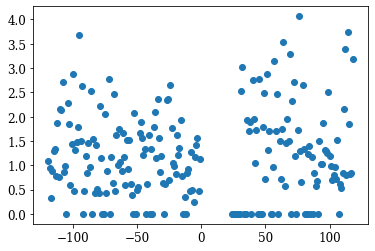

In [48]:
plt.scatter(check_df['date_idx'], check_df['SEVERE_TOXICITY80p'])

In [ ]:
toxicity check_df[check_df['SEVERE_TOXICITY80p'] == 0.0]